In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from IPython.display import Image
import pydotplus
import graphviz
import os
import warnings
warnings.filterwarnings('ignore')

In [7]:
os.chdir('C:\\Users\\liuth\\Documents\\Python Scripts\\ThinkfulProjects\\Data')

In [8]:
df = pd.read_csv('creditcard.csv')

FileNotFoundError: [Errno 2] File b'creditcard.csv' does not exist: b'creditcard.csv'

Classification Problem to identify credit card fraud

---

Data Exploration and Wrangle

In [ ]:
df.head(5)

In [ ]:
df.Class.value_counts()

In [ ]:
# Separate the majority and minority Class.
df_maj = df[df.Class==0]
df_min = df[df.Class==1]


# Downsample majority class 
df_maj_downsampled = resample(df_maj, 
                                 replace=False,    
                                 n_samples=len(df_min))
                                
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_maj_downsampled, df_min])

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), linewidths=0.1, square=True, cmap = "BrBG", linecolor='black', annot=True, ax=ax)

---

This seems like a logistics regression problem to sort out the fraud and non fradulant account

In [ ]:
lr = LogisticRegression()

In [ ]:
X_down = df_downsampled.drop('Class', 1)
Y_down = df_downsampled['Class']


# Use GS-CV to see which alpha level is best.
parameters = {
             'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000,100000,100000000]}

lr_grid = GridSearchCV(lr, parameters, cv=5, verbose=1)

#Fit the logistic regression 
lr_grid.fit(X_down, Y_down)

#return best parameters and best score
print('Best parameters:')
print(lr_grid.best_params_)
print('Best Score:')
print(lr_grid.best_score_)

In [ ]:
cross_val_score(lr_grid, X_down, Y_down, cv=10)

In [5]:
# Declare a logistic regression classifier.
# Parameter regularization coefficient C described above.
lr = LogisticRegression(C=1e9)
y = df_downsampled['Class']
X = df_downsampled[['Amount', 'V1', 'V2']] #the more variables the more it overfits 

# Fit the model.
fit = lr.fit(X, Y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(X)

print('\n Accuracy by Fraud status')
print(pd.crosstab(pred_y_sklearn, y))

print('\n Percentage accuracy')
print(lr.score(X, y))

#class imbalance produces high accuracy, revisit after down sampling.

cross_val_score(lr, X, y, cv=5)

NameError: name 'df_downsampled' is not defined

---

This also seems like a classification problem so lets try using Random Forest to see the outcome

In [13]:
rfc = ensemble.RandomForestClassifier()

#Imbalanced data
X = df_downsampled.drop('Class', 1)
Y = df_downsampled['Class']

# Create rfc parameters for GS-CV
param_grid = {'n_estimators': [10, 25, 50, 75, 100, 200, 500, 1000],
             'max_features': [2, 4, 6, 8],
             'max_depth': [2, 4, 6, 8]} #check bagging and sub-sampling

# Set up GS-CV
grid = GridSearchCV(rfc, param_grid, cv=5, verbose=3, n_jobs=-1)

grid.fit(X, Y)

# Show the best parameter and best score for unfiltered
print('Best Parameter for data:', grid.best_params_)
print('\nBest Score for data:', grid.best_score_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  1.5min finished


Best Parameter for data: {'max_depth': 8, 'max_features': 8, 'n_estimators': 500}

Best Score for data: 0.9400406504065041


In [14]:
cross_val_score(rfc, X, Y, cv=10)

array([0.93      , 0.95      , 0.98979592, 0.8877551 , 0.8877551 ,
       0.92857143, 0.98979592, 0.90816327, 0.94897959, 0.87755102])

---

Decision Tree w/ Visualizations

In [15]:
dtc = DecisionTreeClassifier()

# Set parameters for dtc
dtc_params = [{'max_features': [2, 4, 6, 8],
             'max_depth': [2, 4, 6, 8]}]

# Search for the best paramters. 
dtc_grid = GridSearchCV(dtc, dtc_params, cv=5, verbose=1, n_jobs=1)

# Fit the grid and obtain results
dtc_grid.fit(X_down, Y_down)
# # Render our tree.


# Return best parameters and best score
print('Best parameters:')
print(dtc_grid.best_params_)
print('Best Score:')
print(dtc_grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters:
{'max_depth': 4, 'max_features': 8}
Best Score:
0.9146341463414634


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.7s finished


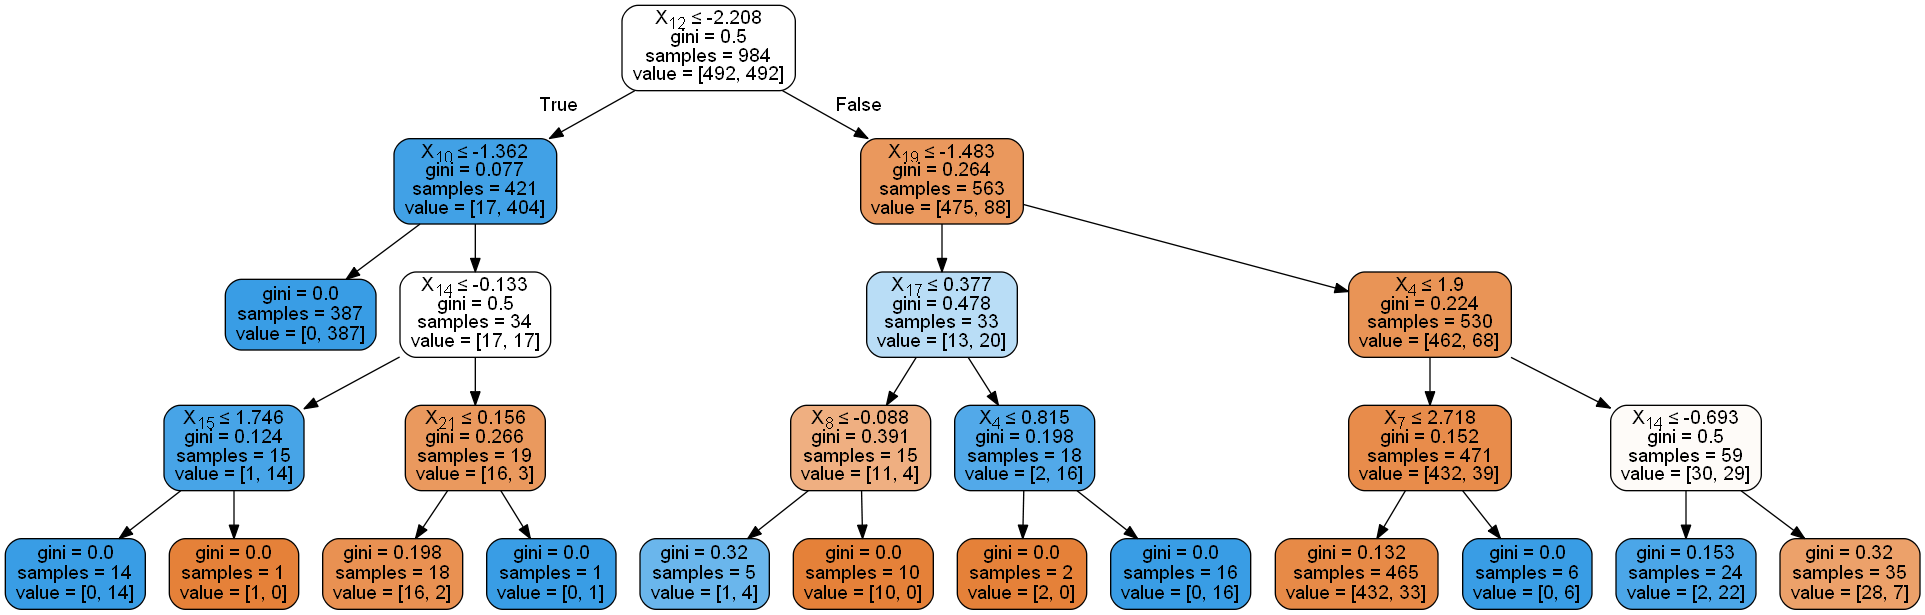

In [20]:
dtc_grid.best_estimator_.fit(X_down, Y_down)
dot_data = tree.export_graphviz(dtc_grid.best_estimator_,
                                out_file=None, filled=True, 
                                rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())